In [1]:
%pylab inline
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
from smalllib import of, ff

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load input data
horizons = pd.read_pickle (of("horizons.pickle"))
stations = pd.read_pickle (of("stations.pickle"))
path = gpd.read_file(of("path.gpkg"), driver="GPKG")

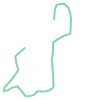

In [3]:
asline = LineString(path.geometry) #  transform the set of points to a linestring
asline

In [4]:
# compute progressive and cumulative distance along the path
path['dist_prev'] = 0
for i in path.index[:-1]:
      path.loc[i+1, 'dist_prev'] = path.loc[i, 'geometry'].distance(path.loc[i+1, 'geometry'])
path["cum_dist"] = path["dist_prev"].cumsum()

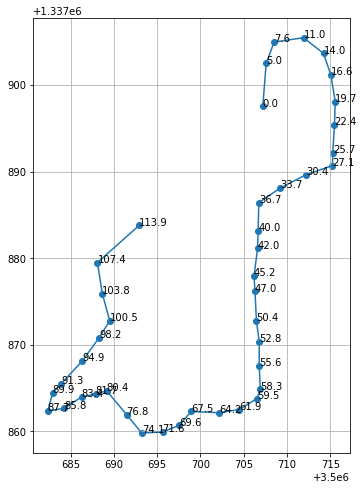

In [5]:
figure(figsize=(8,8))
path.plot(ax=gca())
lll = gpd.GeoDataFrame (geometry=[LineString(path.geometry)])
lll.plot(ax=gca())

for id, (geom, d, n) in path[["geometry", "cum_dist", "progressive_number"]].iterrows():
    pp = np.array(geom.coords)[0]
    text(*pp, s="{:.1f}".format(d))
    
grid()

savefig(ff("prog_distance.png"))

In [6]:
path[0:5] # we display just some of the data to give an idea

,progressive_number,geometry,dist_prev,cum_dist
0,NaN,POINT (3500707.200 1337897.550),0.000000,0.000000
1,1.0,POINT (3500707.589 1337902.527),4.991965,4.991965
2,2.0,POINT (3500708.509 1337904.970),2.610987,7.602951
3,NaN,POINT (3500711.904 1337905.483),3.433670,11.036622
4,NaN,POINT (3500714.217 1337903.661),2.944094,13.980715


Basically the progressive meters in the radargrams starts from stations n 3, and end at 16, the radargram does not cover the full path that was done by the rover. Our "horizons" linestring are expressed in the radargram reference frame, so to correctly translate them to the progressive distance along the path we actually need to find a coordinate transform, for this we can use the stations we know should match up. There might be several ways of doing so, but we prefer to distribute the errors along the path via an inerpolation

In [7]:
out = []

for id, (sid, geometry, progressive_m) in stations.iterrows():
    try :
        sid = np.int(sid) # this will exlude that "8/9" station that was reported in the paper in the same place
    except:
        continue
    
    toget = path.progressive_number == sid
    val = path.cum_dist[toget]
    out.append([sid, progressive_m, np.double(val)])
out   =  np.array(out) 
out
# station id, position in the radargram, position in the overall path
# notice e.g. station 16 is out of several meters, this might be a problem of digitalization of the path. But it is no such a big problem
# because we know that the radargram starts at station 3 and must end at station 16

array([[  3.        ,   0.24185992,  16.63088339],
       [  4.        ,  10.4906358 ,  27.11754401],
       [  5.        ,  20.30461512,  36.6998457 ],
       [  6.        ,  30.83911445,  45.20216385],
       [  7.        ,  36.42935583,  52.81603205],
       [ 10.        ,  50.59130068,  67.45399775],
       [ 11.        ,  59.80898759,  74.05303857],
       [ 12.        ,  67.03903311,  80.38943684],
       [ 13.        ,  74.24423312,  87.69779267],
       [ 14.        ,  77.5238414 ,  91.33155157],
       [ 15.        ,  86.39369107, 100.52574349],
       [ 16.        ,  92.85352556, 107.42006938]])

In [8]:
# we just use a 1-degree polynomial to fit the data
pars = np.polyfit(out[:,1], out[:,2], deg=1) 
predicted =  np.polyval(pars, out[:,1])
err = predicted - out[:,2]

print(pars) # the parameters of the approximating polynomial (first parameter is expected to be around 1)
print(err) # the error at each station

[ 0.96750205 16.69136384]
[ 0.29448042 -0.27646849 -0.36372504  1.32610654 -0.87919165 -1.81544662
  0.50364356  1.16232918  0.82501915  0.36428801 -0.24830615 -0.89272891]


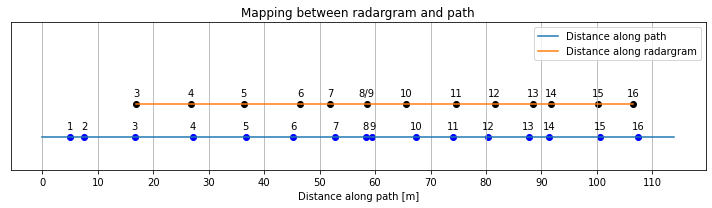

In [9]:
# we create a nice plot to show the idea here
figure(figsize=(10,3))
xlabel("Distance along path [m]")

out = []
tout = []
for id, (sid, d) in path[["progressive_number", "cum_dist"]].iterrows():  
    x = d
    y = 0
    out.append([x,y])
    if ~np.isnan(sid):
        tout.append([sid, [x,y]])
    
    
    
out=np.array(out)

plot(*out.T, label="Distance along path")
dy = 0.025

for id, (x,y) in tout:
    text(x,y+dy, f"{np.int(id)}", horizontalalignment="center")
    scatter(x,y, color="b")

line = []
for id, (sid, d) in stations[["sid", "progressive_m"]].iterrows():
    x = d*pars[0] + pars[1]
    y = 0.1
    scatter(x,y, color="black")
    text(x,y+dy, f"{sid}", horizontalalignment="center")
    line.append([x,y])
    
plot(*np.array(line).T,  label="Distance along radargram")
lgd =legend()



gca().get_yaxis().set_visible(False)
grid()
xticks(np.arange(0, 120, 10.0))
title("Mapping between radargram and path")
# tight_layout()

ylim(-0.1, 0.35)
tight_layout()

savefig(ff("mapping.png"), dpi=300, transparent=0,)


In [10]:
# we can now process each horizon and append the result to out
out = []
for id, (hid, geometry) in horizons.iterrows():
    pts = np.array(geometry.coords) # original coord in the radargram
    newpts = []
    for pd,elev in pts:
        # point cumulative distance position on the full radargram
        onpath_prog_d = np.polyval(pars, pd) # apply the trasform from radargram progressive distance to
                                             # full path progressive distance
                                            
        # estimate the point on the "asline" path
        xy_pt = asline.interpolate(onpath_prog_d)
        x,y = np.array(xy_pt.coords)[0] # extract x,y value
        newpts.append([x,y,elev]) # append a point of the horizon
    out.append(np.array(newpts)) # append the points of the horizon to out

out contains the two dimensional coordinate (map coordinates) of the nodes of the horizons, third column is the elevation in m from the surface

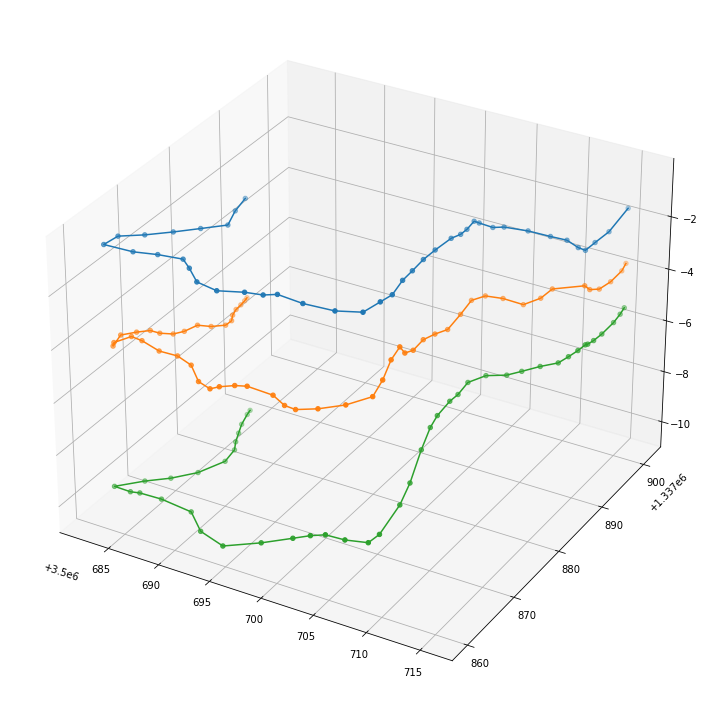

In [11]:
# a first very simple 3d view of the data, we will see soon how to actually visualize all the data in 3D, 
# but this is enough for a visual check

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for i in np.arange(3):
    ax.scatter(*out[i].T)
    ax.plot(*out[i].T)
    
tight_layout()
savefig(ff("3d_simple.png"), dpi=300)

In [12]:
np.savez(of("horizons"), out) # save, using numpy.savez here

/usr/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
